In [0]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading the dataset:

Yahoo Stock (from July 2015 to April 2020) has been collected to be used in training. 

The companies used are part of the Nifty50 group of companies as of 17 November 2019​.

The dataset collected consists of 8 features (date, open, high, low, close, volume, adj close, comp), 4 Technical indicators and the company category. 


In [4]:
df=pd.read_csv("/content/drive/My Drive/final_dataset.csv")
df=df.drop(['Unnamed: 0'],axis=1)
df

,Category,date,high,low,open,close,volume,adj_close,comp,wr,moving_avg,RSI,stoch
0,Transportation,01-07-2015,312.700012,306.500000,308.799988,311.299988,2854143,303.809296,Adani Ports & SEZ,-22.580994,311.299988,0.000000,77.419006
1,Transportation,02-07-2015,319.000000,311.899994,312.450012,316.049988,8669541,308.445007,Adani Ports & SEZ,-23.600098,313.674988,0.000000,76.399902
2,Transportation,03-07-2015,325.750000,319.000000,319.950012,320.799988,5189498,313.080688,Adani Ports & SEZ,-25.714349,316.049988,0.000000,74.285651
3,Transportation,06-07-2015,321.100006,316.250000,316.950012,320.100006,2853145,312.397553,Adani Ports & SEZ,-29.350618,317.062492,0.000000,70.649382
4,Transportation,07-07-2015,334.700012,321.600006,321.799988,333.049988,7877450,325.035919,Adani Ports & SEZ,-5.851148,320.259991,93.137435,94.148852
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58695,NaN,01-04-2020,126.750000,120.000000,124.000000,120.900002,6571413,120.900002,ZEEL,-91.958041,141.136667,30.112364,8.263475
58696,NaN,03-04-2020,125.949997,119.050003,123.000000,124.349998,7887911,124.349998,ZEEL,-87.604792,136.716668,31.874355,14.577463
58697,NaN,07-04-2020,143.000000,126.650002,129.000000,140.899994,11487040,140.899994,ZEEL,-62.112685,133.923334,39.689528,37.887315
58698,NaN,08-04-2020,148.149994,135.250000,138.000000,143.149994,10046602,143.149994,ZEEL,-58.943671,132.376666,40.680751,41.056329


Coverting the date column from string format to datetime format for easy visualization:

In [0]:
df['date'] = pd.to_datetime(df.date,format='%d-%m-%Y')

Choosing the company we wish to train the model on:

In [6]:
df=df[df['comp']=='Adani Ports & SEZ']
df

,Category,date,high,low,open,close,volume,adj_close,comp,wr,moving_avg,RSI,stoch
0,Transportation,2015-07-01,312.700012,306.500000,308.799988,311.299988,2854143,303.809296,Adani Ports & SEZ,-22.580994,311.299988,0.000000,77.419006
1,Transportation,2015-07-02,319.000000,311.899994,312.450012,316.049988,8669541,308.445007,Adani Ports & SEZ,-23.600098,313.674988,0.000000,76.399902
2,Transportation,2015-07-03,325.750000,319.000000,319.950012,320.799988,5189498,313.080688,Adani Ports & SEZ,-25.714349,316.049988,0.000000,74.285651
3,Transportation,2015-07-06,321.100006,316.250000,316.950012,320.100006,2853145,312.397553,Adani Ports & SEZ,-29.350618,317.062492,0.000000,70.649382
4,Transportation,2015-07-07,334.700012,321.600006,321.799988,333.049988,7877450,325.035919,Adani Ports & SEZ,-5.851148,320.259991,93.137435,94.148852
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,Transportation,2020-04-01,247.800003,235.050003,246.050003,244.800003,4034211,244.800003,Adani Ports & SEZ,-57.735080,255.099999,33.572445,42.784031
1170,Transportation,2020-04-03,252.800003,238.899994,246.000000,244.800003,7210403,244.800003,Adani Ports & SEZ,-57.215969,252.243333,33.572445,52.022402
1171,Transportation,2020-04-07,255.850006,245.600006,254.199997,248.100006,7360798,248.100006,Adani Ports & SEZ,-43.870563,249.266667,35.331183,56.129437
1172,Transportation,2020-04-08,255.850006,242.750000,248.000000,250.850006,6897792,250.850006,Adani Ports & SEZ,-40.448037,248.563334,36.824605,68.357152


In [7]:
df.shape

(1174, 13)

A visualization of the company's closing price by date over 5 years:

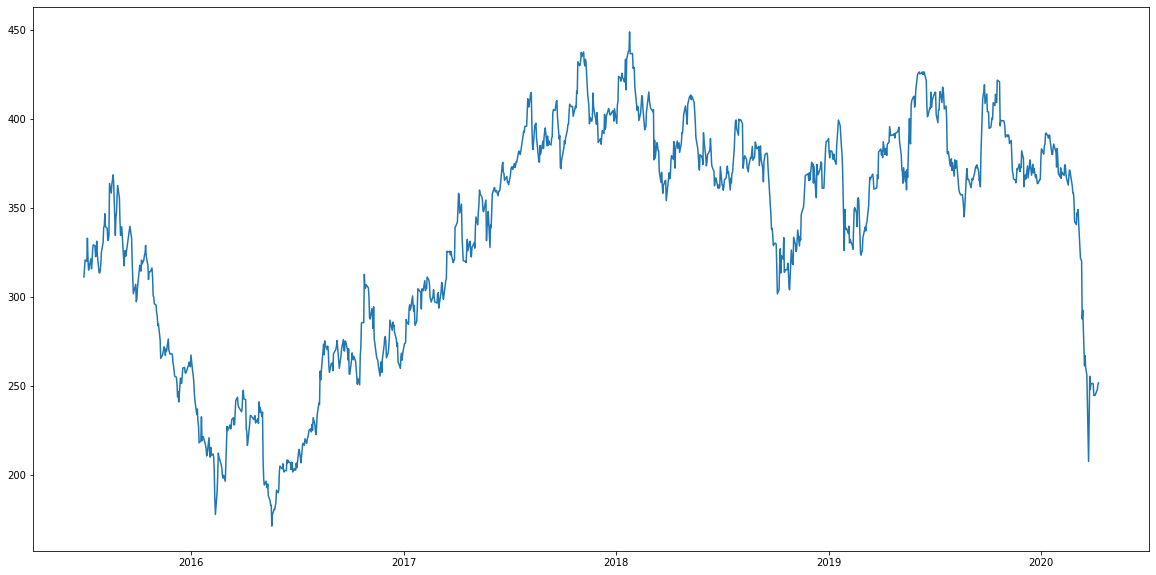

In [8]:
#plot
plt.plot(df['date'],np.asarray(df['close']), label='Close Price history')

## 1) Moving Average

This is a good starting point to use on our dataset for making predictions.

The predicted closing price for each day will be the average of a specific number of days prior which will include observed values and predicted values. We wil keep removing oldest observed values as the latest predicted values are taken into consideration.

The moving average will remove all the noise in the data and provide a general sense of the direction the price is moving.

In [0]:
X_ma=df[['date','adj_close']]

Taking a training set of 700 (i.e. we start with a lookback period of 700 days) and predicting the rest:

In [0]:
preds=np.array(X_ma['adj_close'][:700])
for i in range(700,X_ma.shape[0]):
    a=np.mean(preds[i-700:])
    preds=np.append(preds,a)

In [11]:
preds.shape

(1174,)

Let us calculate the Root Mean Square Error:

In [12]:
rms=np.sqrt(np.mean(np.square((X_ma['adj_close'][700:])-preds[700:])))
rms

54.87288656287298

Just checking the RMSE does not help us in understanding how the model performed. Let’s visualize this to get a more intuitive understanding. So here is a plot of the predicted values along with the actual values.

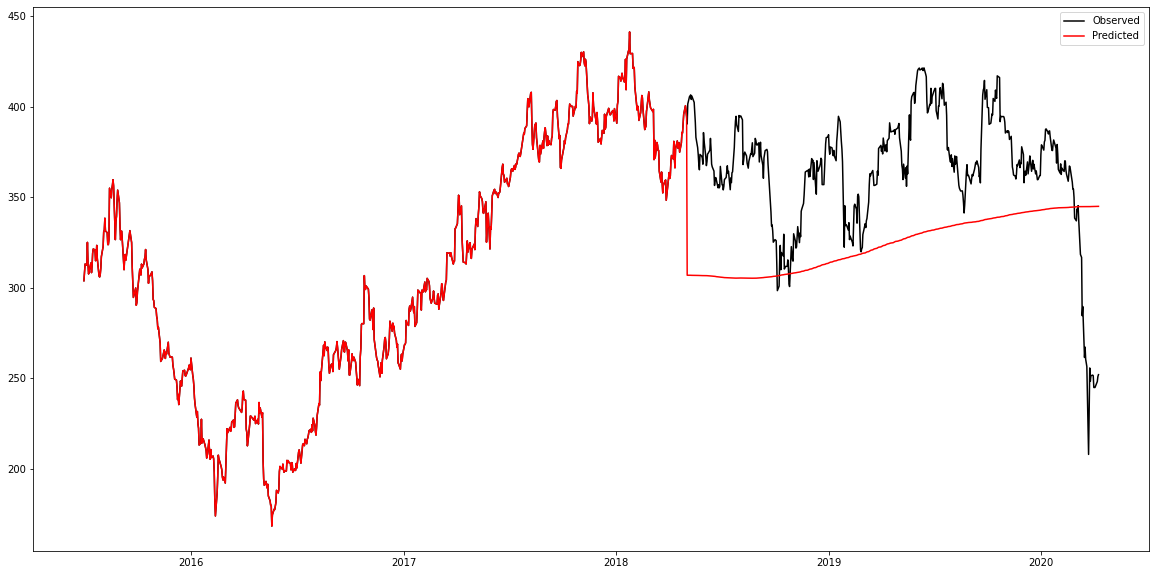

In [13]:
plt.plot(df['date'],np.asarray(X_ma['adj_close']),c='k',label='Observed')
plt.plot(df['date'],preds,c='r',label='Predicted')
plt.legend()
plt.show()

# 2) Linear Regression

The most basic machine learning algorithm that can be implemented on this data is linear regression. 

The linear regression model returns a linear equation that determines the relationship between the independent variables and the dependent variable.


Let us consider the TIs as the predicting features:

In [0]:
X_lr=df[['date','wr',	'moving_avg'	,'RSI',	'stoch']]
y_lr=df['adj_close']
y_lr=np.asarray(y_lr)

Split the data into training and testing:

In [0]:
X_train=X_lr[:int(0.8*len(X_lr))]
X_train_date=df['date'][:int(0.8*len(X_lr))]
X_test=X_lr[int(0.8*len(X_lr)):]
X_test_date=df['date'][int(0.8*len(X_lr)):]
y_train=y_lr[:int(0.8*len(y_lr))]
y_test=y_lr[int(0.8*len(y_lr)):]

In [0]:
X_train=(X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_test=(X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))

Initialising the weights and fitting the data to the model:

In [17]:
n=5
m=len(X_train)
y = np.array(y_train)
y = np.reshape(y_train,(y_train.shape[0],1))
t = np.ones((m,1))
x = np.hstack((t,X_train))
w=np.zeros(n+1)
w= np.array(w)
w = np.reshape(w,(1,w.shape[0]))
print(y.shape)
print(w.shape)
print(x.shape)

(939, 1)
(1, 6)
(939, 6)


Setting learning rate as 0.1 and taking 1000 iterations and applying gradient descent:

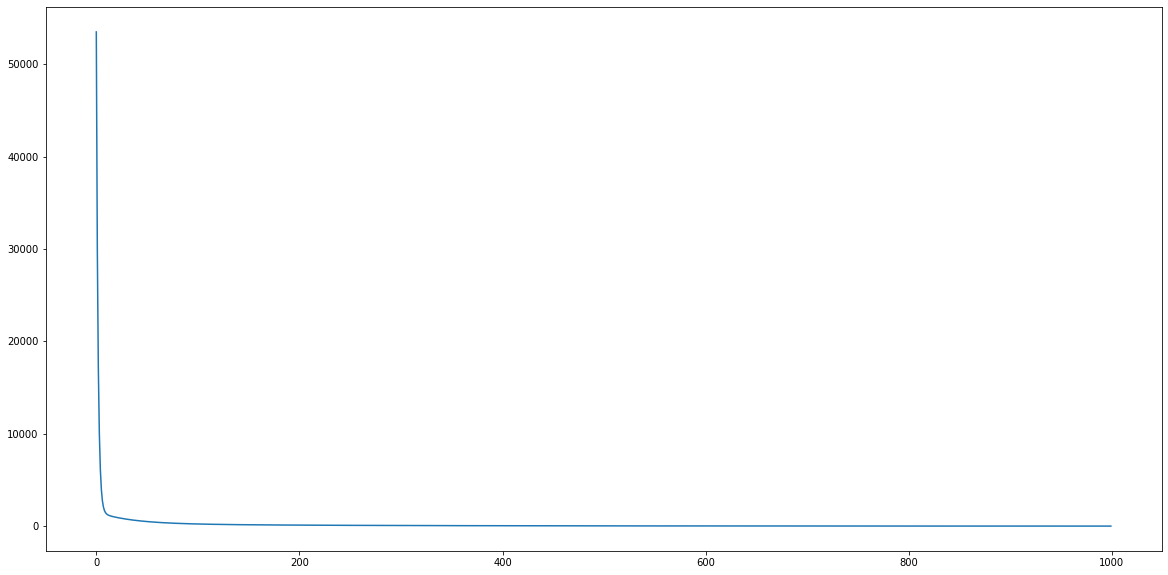

In [18]:
alpha=0.1
t=1000
temp = np.zeros((n+1,1))
cost_log = []
for k in range(t):
  hwx = np.dot(x,w.T)
  for i in range(n+1):
      temp[i] = w[0,i] - alpha*(1./m)*(np.sum( (hwx-y)*x[:,i:i+1]))
  for i in range(n+1):
      w[0,i] = temp[i]
  J = (1/(2*m))*np.sum(np.square(hwx-y))
  cost_log = np.append(cost_log, J)
plt.plot(np.arange(t), cost_log)

We know the Linear regression model is being trained correctly because the error constantly reduces over the iterations. 

Let us test the model:

In [0]:
n=5
m=len(X_test)
y = np.array(y_test)
y = np.reshape(y_test,(y_test.shape[0],1))
t = np.ones((m,1))
x = np.hstack((t,X_test))


We will now predict the values and find the RMS error:

In [20]:
hwx=np.dot(x,w.T)
J = np.sqrt(np.mean(np.square(hwx-y)))
J

15.58222413737763

In [21]:
hwx.shape

(235, 1)

Visualising the performance of linear regression:

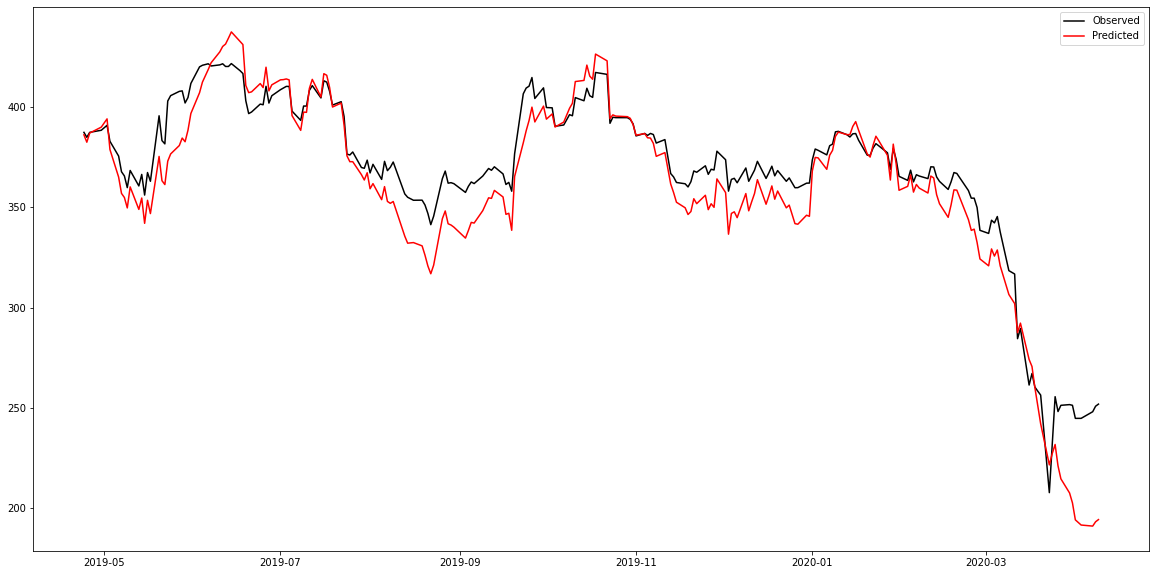

In [22]:
plt.plot(X_test_date,y_test,c='k',label='Observed')
plt.plot(X_test_date,hwx,c='r',label='Predicted')
plt.legend()
plt.show()

# 3) KNN

KNN is a simple supervised learning algorithm that uses similarity index (based on Euclidean distance) to compare a given test sample with training data samples. KNN selects k records of training data that are closest to the test sample.

KNN is considered lazy learning since it does not build a model aprior, but yields similar training samples at the time of prediction.

A majority vote among the top k determines the value to be assigned to the test record.


In [0]:
X_knn=df[['wr',	'moving_avg'	,'RSI',	'stoch']]
y_knn=df['adj_close']
y_knn=np.asarray(y_knn)

In [0]:
X_train=X_knn[:int(0.8*len(X_knn))]
X_train_date=df['date'][:int(0.8*len(X_knn))]
X_test=X_knn[int(0.8*len(X_knn)):]
X_test_date=df['date'][int(0.8*len(X_knn)):]
y_train=y_knn[:int(0.8*len(y_knn))]
y_test=y_knn[int(0.8*len(y_knn)):]

In [0]:
X_train=(X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_test=(X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))

Taking k=20 we will calculate the RMS error in the predictions:-

In [26]:
# taking k as 20
k=20
err=[]
pred=[]
for i in range(len(X_test)):
    final=defaultdict(int)
    sor=[]
    for j in range(len(X_train)):
      dist=np.sum(np.square(np.asarray(X_test)[i]-np.asarray(X_train)[j]))  #take euclidean distance of test sample from each training sample
      sor.append((dist,j))
    knn=sorted(sor) #sort in ascending order
    # print(knn)
    for l in range(k):
      final[np.asarray(y_train)[knn[l][1]]]+=1 #taking the vote of each label from the k closest training samples
    cls=max(final,key=final.get) 
    pred.append(cls) 
    err.append(abs(cls-y_test[i]))

print("RMS error: ",np.sqrt(np.mean(np.square(err))))

RMS error:  19.55873119831114


Let us visualize the performance:

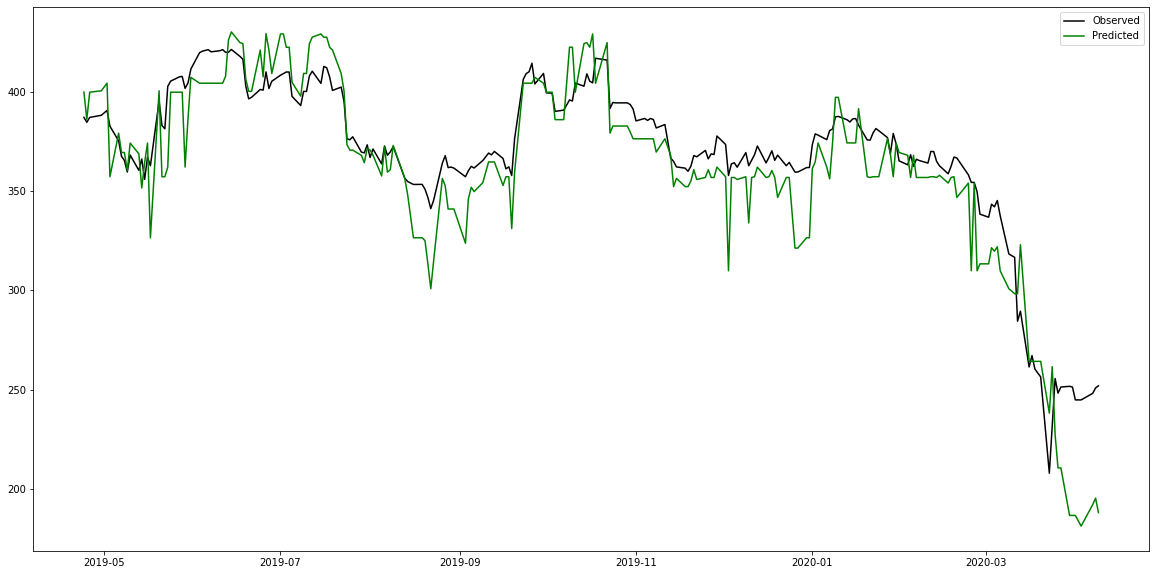

In [27]:
plt.plot(X_test_date,y_test,c='k',label='Observed')
plt.plot(X_test_date,pred,c='g',label='Predicted')
plt.legend()
plt.show()

A comparative report of linear regression and KNN both of which performed better than moving average:

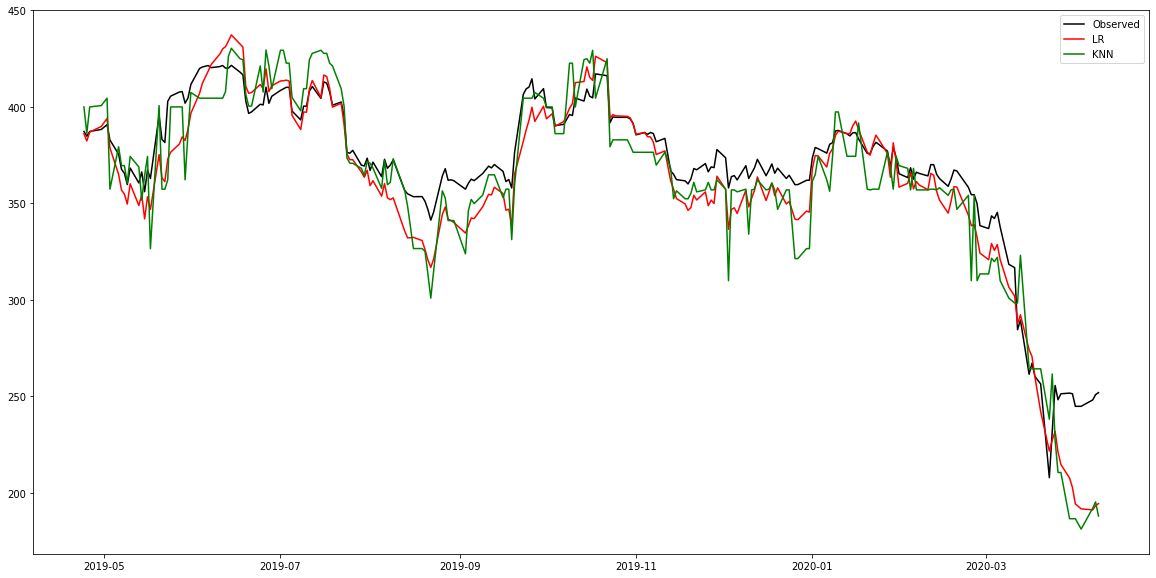

In [28]:
plt.plot(X_test_date,y_test,c='k',label='Observed')
plt.plot(X_test_date,hwx,c='r',label='LR')
plt.plot(X_test_date,pred,c='g',label='KNN')
plt.legend()
plt.show()